=========================================================================<br>
  (c) Copyright 2020<br>
  All rights reserved<br>
  Programs written by Hao Liu<br>
  Department of Computer Science<br>
  New Jersey Institute of Technology<br>
  University Heights, Newark, NJ 07102, USA<br>
<br>
  Permission to use, copy, modify, and distribute this<br>
  software and its documentation for any purpose and without<br>
  fee is hereby granted, provided that this copyright<br>
  notice appears in all copies. Programmer(s) makes no<br>
  representations about the suitability of this<br>
  software for any purpose.  It is provided "as is" without<br>
  express or implied warranty.<br>
=========================================================================

# **Packages**

In [7]:
!pip install shap
!pip install lime
!pip install yellowbrick
!pip install witwidget
!pip install interpret

# **Imports**

In [8]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.utils import class_weight
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
from sklearn.inspection import PartialDependenceDisplay
from mpl_toolkits.mplot3d import Axes3D
from sklearn.inspection import partial_dependence
import numpy as np
import tensorflow as tf
import random
import os
import sys
import csv

# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Stop randomness for consistent results
os.environ['PYTHONHASHSEED'] = '42'

import warnings
from keras import regularizers
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from yellowbrick.classifier import PrecisionRecallCurve
import lime
from lime.lime_tabular import LimeTabularExplainer
import random

In [9]:
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
try:
    import tensorflow as tf
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception as e:
    print('turn off loggins is not supported')

# **Functions**

In [10]:
def load_data(datafile, series_len, start_feature, n_features, mask_value, type, forecast_horizon):
    df = pd.read_csv(datafile, header=None)
    df_values0 = df.values
    if type == 'gru':
        if forecast_horizon == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif forecast_horizon == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif forecast_horizon == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif forecast_horizon == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif forecast_horizon == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif type == 'lstm':
        if forecast_horizon == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif forecast_horizon == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif forecast_horizon == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif forecast_horizon == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif forecast_horizon == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    X = []
    y = []
    tmp = []
    for k in range(start_feature, start_feature + n_features):
        tmp.append(mask_value)
    n_neg = 0
    n_pos = 0
    for idx in range(0, len(df_values)):
        each_series_data = []
        row = df_values[idx]
        label = row[0]
        if label == 'padding':
            continue
        has_zero_record = False
        # if one of the physical feature values is missing, then discard it.
        for k in range(start_feature, start_feature + n_features):
            if float(row[k]) == 0.0:
                has_zero_record = True
                break
        if has_zero_record is False:
            cur_harp_num = int(row[3])
            each_series_data.append(row[start_feature:start_feature + n_features].tolist())
            itr_idx = idx - 1
            while itr_idx >= 0 and len(each_series_data) < series_len:
                prev_row = df_values[itr_idx]
                prev_harp_num = int(prev_row[3])
                if prev_harp_num != cur_harp_num:
                    break
                has_zero_record_tmp = False
                for k in range(start_feature, start_feature + n_features):
                    if float(prev_row[k]) == 0.0:
                        has_zero_record_tmp = True
                        break
                if float(prev_row[-5]) >= 3500 or float(prev_row[-4]) >= 65536 or \
                        abs(float(prev_row[-1]) - float(prev_row[-2])) > 70:
                    has_zero_record_tmp = True
                if len(each_series_data) < series_len and has_zero_record_tmp is True:
                    each_series_data.insert(0, tmp)
                if len(each_series_data) < series_len and has_zero_record_tmp is False:
                    each_series_data.insert(0, prev_row[start_feature:start_feature + n_features].tolist())
                itr_idx -= 1
            while len(each_series_data) > 0 and len(each_series_data) < series_len:
                each_series_data.insert(0, tmp)
            if (label == 'N' or label == 'P') and len(each_series_data) > 0:
                X.append(np.array(each_series_data).reshape(series_len, n_features).tolist())
                if label == 'N':
                    y.append(0)
                    n_neg += 1
                elif label == 'P':
                    y.append(1)
                    n_pos += 1
    X_arr = np.array(X)
    y_arr = np.array(y)
    nb = n_neg + n_pos
    return X_arr, y_arr, nb

In [11]:
def attention_3d_block(hidden_states, series_len):
    hidden_size = int(hidden_states.shape[2])
    hidden_states_t = Permute((2, 1), name='attention_input_t')(hidden_states)
    hidden_states_t = Reshape((hidden_size, series_len), name='attention_input_reshape')(hidden_states_t)
    score_first_part = Dense(series_len, use_bias=False, name='attention_score_vec')(hidden_states_t)
    score_first_part_t = Permute((2, 1), name='attention_score_vec_t')(score_first_part)
    h_t = Lambda(lambda x: x[:, :, -1], output_shape=(hidden_size, 1), name='last_hidden_state')(hidden_states_t)
    score = dot([score_first_part_t, h_t], [2, 1], name='attention_score')
    attention_weights = Activation('softmax', name='attention_weight')(score)
    context_vector = dot([hidden_states_t, attention_weights], [2, 1], name='context_vector')
    context_vector = Reshape((hidden_size,))(context_vector)
    h_t = Reshape((hidden_size,))(h_t)
    pre_activation = concatenate([context_vector, h_t], name='attention_output')
    attention_vector = Dense(hidden_size, use_bias=False, activation='tanh', name='attention_vector')(pre_activation)
    return attention_vector

In [12]:
def lstm(n_features, series_len):
    inputs = Input(shape=(series_len, n_features,))
    lstm_out = LSTM(10, return_sequences=True, dropout=0.5, recurrent_dropout=0.3)(inputs)
    attention_mul = attention_3d_block(lstm_out, series_len)
    layer1 = Dense(100, activation='relu')(attention_mul)
    layer1 = Dropout(0.25)(layer1)
    output = Dense(1, activation='sigmoid', activity_regularizer=regularizers.l2(0.0001))(layer1)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [13]:
def output_result(test_data_file, result_file, type, forecast_horizon, start_feature, n_features, thresh):
    df = pd.read_csv(test_data_file, header=None)
    df_values0 = df.values
    if type == 'gru':
        if forecast_horizon == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 7, 8, 15, 18, 21, 6, 9, 10, 17, 5, 16, 4, 12, 19, 20, 14]]  # 12   GRU
        elif forecast_horizon == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 15, 5, 20, 9, 21, 7, 8, 6, 17, 18, 10, 14, 4, 12, 16, 19]]  # 24   GRU
        elif forecast_horizon == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 21, 15, 8, 7, 4, 6, 14, 12, 17, 10, 18, 16, 19]]  # 36   GRU
        elif forecast_horizon == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 9, 14, 8, 7, 21, 6, 4, 15, 12, 17, 16, 10, 18, 19]]  # 48   GRU
        elif forecast_horizon == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   GRU
    elif type == 'lstm':
        if forecast_horizon == 12:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 13, 20, 7, 15, 8, 21, 6, 18, 5, 10, 9, 17, 16, 19, 12, 14, 4]]  # 12   LSTM
        elif forecast_horizon == 24:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 20, 11, 13, 9, 15, 14, 8, 7, 5, 21, 6, 17, 18, 10, 12, 16, 4, 19]]  # 24   LSTM
        elif forecast_horizon == 36:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 20, 13, 5, 14, 8, 15, 7, 9, 21, 6, 4, 12, 17, 18, 10, 16, 19]]  # 36   LSTM
        elif forecast_horizon == 48:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 20, 13, 9, 14, 7, 15, 8, 6, 4, 21, 12, 17, 18, 16, 10, 19]]  # 48   LSTM
        elif forecast_horizon == 60:
            df_values = df_values0[:,
                        [0, 1, 2, 3, 11, 5, 13, 20, 7, 15, 8, 14, 6, 21, 4, 9, 12, 10, 19, 18, 16, 17]]  # 60   LSTM
    with open(result_file, 'w', encoding='UTF-8') as result_csv:
        w = csv.writer(result_csv)
        w.writerow(['Predicted Label', 'Label', 'Timestamp', 'NOAA AR NUM', 'HARP NUM',
                      'TOTUSJH', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'AREA_ACR',
                      'MEANPOT', 'R_VALUE', 'SHRGT45', 'MEANGAM', 'MEANJZH', 'MEANGBT', 'MEANGBZ',
                      'MEANJZD', 'MEANGBH', 'MEANSHR', 'MEANALP'])
        idx = 0
        for i in range(len(df_values)):
            line = df_values[i].tolist()
            if line[0] == 'padding' or float(line[-5]) >= 3500 or float(line[-4]) >= 65536 \
                    or abs(float(line[-1]) - float(line[-2])) > 70:
                continue
            has_zero_record = False
            # if one of the physical feature values is missing, then discard it.
            for k in range(start_feature, start_feature + n_features):
                if float(line[k]) == 0.0:
                    has_zero_record = True
                    break
            if has_zero_record:
                continue
            if prob[idx] >= thresh:
                line.insert(0, 'P')
            else:
                line.insert(0, 'N')
            idx += 1
            w.writerow(line)

In [14]:
def get_n_features_thresh(type, forecast_horizon):
    n_features = 0
    thresh = 0
    if type == 'gru':
        if forecast_horizon == 12:
            n_features = 16
            thresh = 0.45
        elif forecast_horizon == 24:
            n_features = 12
            thresh = 0.4
        elif forecast_horizon == 36:
            n_features = 9
            thresh = 0.45
        elif forecast_horizon == 48:
            n_features = 14
            thresh = 0.45
        elif forecast_horizon == 60:
            n_features = 5
            thresh = 0.5
    elif type == 'lstm':
        if forecast_horizon == 12:
            n_features = 15
            thresh = 0.4
        elif forecast_horizon == 24:
            n_features = 12
            thresh = 0.45
        elif forecast_horizon == 36:
            n_features = 8
            thresh = 0.45
        elif forecast_horizon == 48:
            n_features = 15
            thresh = 0.45
        elif forecast_horizon == 60:
            n_features = 6
            thresh = 0.5
    return n_features, thresh

# **Main**

In [15]:
if __name__ == '__main__':
    type = 'lstm'
    forecast_horizon = 24
    train_again = 0
    train_data_file = './normalized_training_' + str(forecast_horizon) + '.csv'
    test_data_file = './normalized_testing_' + str(forecast_horizon) + '.csv'
    result_file = './' + type + '-' + str(forecast_horizon) + '-output.csv'
    model_file = './' + type + '-' + str(forecast_horizon) + '-model.h5'
    start_feature = 4
    n_features, thresh = get_n_features_thresh(type, forecast_horizon)
    mask_value = 0
    series_len = 20
    epochs = 20
    batch_size = 256
    nclass = 2

# **Features**

In [16]:
    feature_names = ['MEANSHR', 'MEANPOT', 'SHRGT45', 'USFLUX', 'MEANJZH', 'MEANGAM', 'SAVNCPP', 'ABSNJZH', 'TOTPOT', 'MEANALP', 'TOTUSJZ', 'MEANGBZ']

# **Train**

In [17]:
    # Train
    print('loading training data...')
    X_train, y_train, nb_train = load_data(datafile=train_data_file,
                                            series_len=series_len,
                                            start_feature=start_feature,
                                            n_features=n_features,
                                            mask_value=mask_value,
                                            type=type,
                                            forecast_horizon=forecast_horizon)
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                    classes=np.unique(y_train),
                                                    y=y_train)
    class_weight_ = {0: class_weights[0], 1: class_weights[1]}
    print('done loading training data...')
    if type == 'gru':
        model = gru(n_features, series_len)
    elif type == 'lstm':
        model = lstm(n_features, series_len)
    print('training the model, wait until it is finished...')
    model.compile(loss='binary_crossentropy',
                    optimizer='RMSprop',
                    metrics=['accuracy'])
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=False,
                        shuffle=True,
                        class_weight=class_weight_)
    print('finished...')
    model.save(model_file)

loading training data...
done loading training data...
training the model, wait until it is finished...


finished...


# **Test**

In [18]:
    # Test
    print('loading testing data')
    X_test, y_test, nb_test = load_data(datafile=test_data_file,
                                        series_len=series_len,
                                        start_feature=start_feature,
                                        n_features=n_features,
                                        mask_value=mask_value,
                                        type=type,
                                        forecast_horizon=forecast_horizon)
    print('done loading testing data...')
    print('predicting testing data...')
    prob = model.predict(X_test,
                         batch_size=batch_size,
                         verbose=False,
                         steps=None)
    print('done predicting...')

loading testing data
done loading testing data...
predicting testing data...
done predicting...


In [19]:
    print(f'X_test shape: {X_test.shape}')
    print(f'X_train shape: {X_train.shape}')

X_test shape: (540, 20, 12)
X_train shape: (33604, 20, 12)


# **Reshaped**

In [20]:
    X_train_mean = X_train.mean(axis=1)
    X_test_mean = X_test.mean(axis=1)
    X_train_flattened = X_train.reshape(X_train.shape[0], -1)
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# **Yellowbrick (YB)**

Feature Visualization

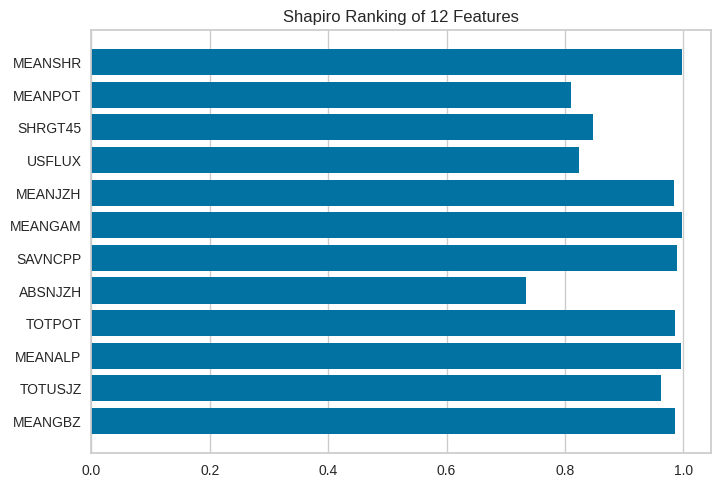

<Axes: title={'center': 'Shapiro Ranking of 12 Features'}>

In [21]:
    # Rank 1D
    from yellowbrick.features import Rank1D

    visualizer = Rank1D(algorithm='shapiro', features=feature_names)

    visualizer.fit(X_train_mean, y_train)
    visualizer.transform(X_train_mean)
    visualizer.show()

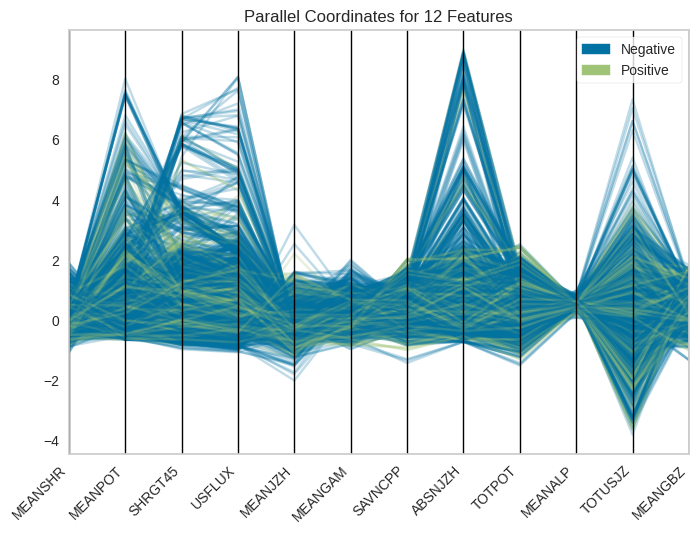

<Axes: title={'center': 'Parallel Coordinates for 12 Features'}>

In [22]:
    # Parallel Coordinates
    from yellowbrick.features import ParallelCoordinates

    classes = ['Negative', 'Positive']

    visualizer = ParallelCoordinates(sample=0.05, shuffle=True, classes=classes, features=feature_names)
    visualizer.fit_transform(X_train_mean, y_train)
    plt.xticks(rotation=45, ha='right')
    visualizer.show()

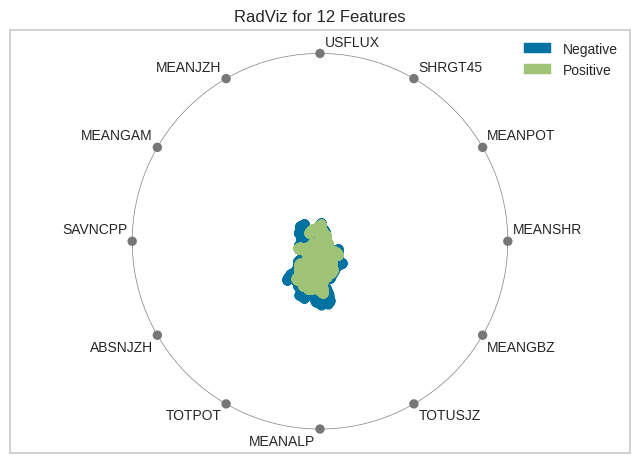

<Axes: title={'center': 'RadViz for 12 Features'}>

In [23]:
    # Radial Visualization
    from yellowbrick.features import RadViz

    visualizer = RadViz(classes=['Negative', 'Positive'], features=feature_names)

    visualizer.fit(X_train_mean, y_train)
    visualizer.show()

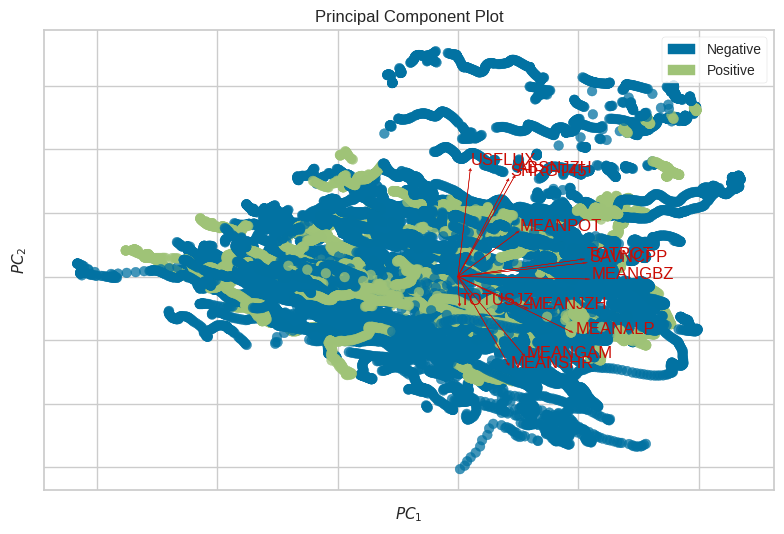

<Axes: title={'center': 'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [24]:
    # PCA Biplot
    from yellowbrick.features import PCA

    classes=['Negative', 'Positive']
    visualizer = PCA(scale=True, n_components=12, classes=classes, proj_features=True, features=feature_names)

    visualizer.fit_transform(X_train_mean, y_train)
    visualizer.show()

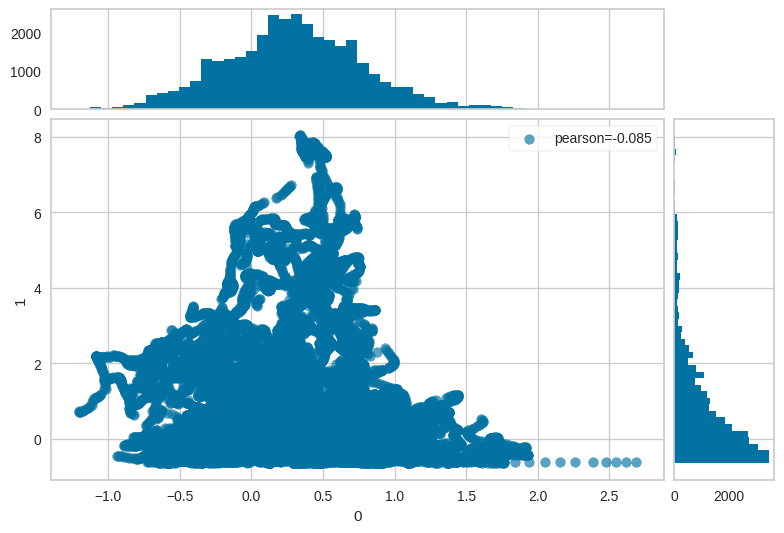

<Axes: xlabel='0', ylabel='1'>

In [25]:
    # Joint Plot
    from yellowbrick.features import JointPlotVisualizer

    visualizer = JointPlotVisualizer(columns=[0,1])

    visualizer.fit_transform(X_train_mean, y_train)
    visualizer.show()

Target Visualization

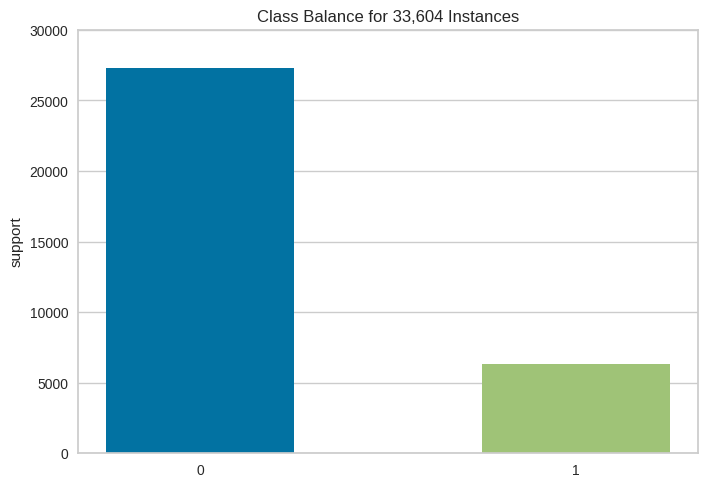

<Axes: title={'center': 'Class Balance for 33,604 Instances'}, ylabel='support'>

In [26]:
    # Class Balance
    from yellowbrick.target import ClassBalance

    visualizer = ClassBalance()

    visualizer.fit(y_train)
    visualizer.show()

# **Morris Sensitivity Analysis (MSA)**

In [27]:
    import tensorflow as tf
    from interpret import show
    from interpret.blackbox import MorrisSensitivity

    MSA_X_train_mean = np.mean(X_train, axis=1)
    input_shape = model.input_shape[1:]

    class WrappedModel:
        def __init__(self, model, input_shape):
            self.model = model
            self.input_shape = input_shape

        def predict(self, X):
            reshaped_input = np.repeat(X[:, np.newaxis, :], self.input_shape[0], axis=1)
            predictions = self.model.predict(reshaped_input)
            return predictions

        def __call__(self, X):
            return self.predict(X)

    wrapped_model = WrappedModel(model, input_shape)
    msa = MorrisSensitivity(wrapped_model, MSA_X_train_mean)

    explanation = msa.explain_global()
    explanation.data()['names'] = feature_names
    show(explanation)

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
407/407 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


# **Local Interpretable Model-Agnostic Explanations (LIME)**

In [28]:
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_train_mean,
        feature_names=feature_names,
        mode='classification',
        random_state=42 # reproduce randomness in LIME
    )

    def predict_fn_mean(X):
        X_reshaped = np.repeat(X[:, np.newaxis, :], repeats=series_len, axis=1)
        prob = model.predict(X_reshaped)
        return np.hstack((1 - prob, prob))

    exp = explainer.explain_instance(
        data_row=X_test_mean[55],
        predict_fn=predict_fn_mean,
        num_features=12
    )

    exp.show_in_notebook(show_table=True, show_all=False)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


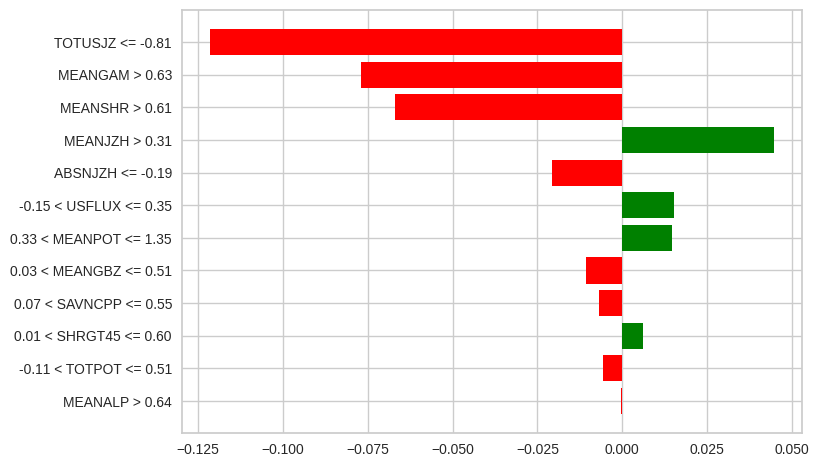

In [29]:
    fig = exp.as_pyplot_figure()
    plt.gca().set_title('')
    plt.show()

# **SHapley Additive exPlanations (SHAP)**

In [30]:
    explainer = shap.GradientExplainer(model, X_train)
    shap_values = explainer.shap_values(X_test)

In [31]:
    shap_values_mean = shap_values.mean(axis=1)
    shap_values_squeezed = np.squeeze(shap_values_mean, axis=-1)

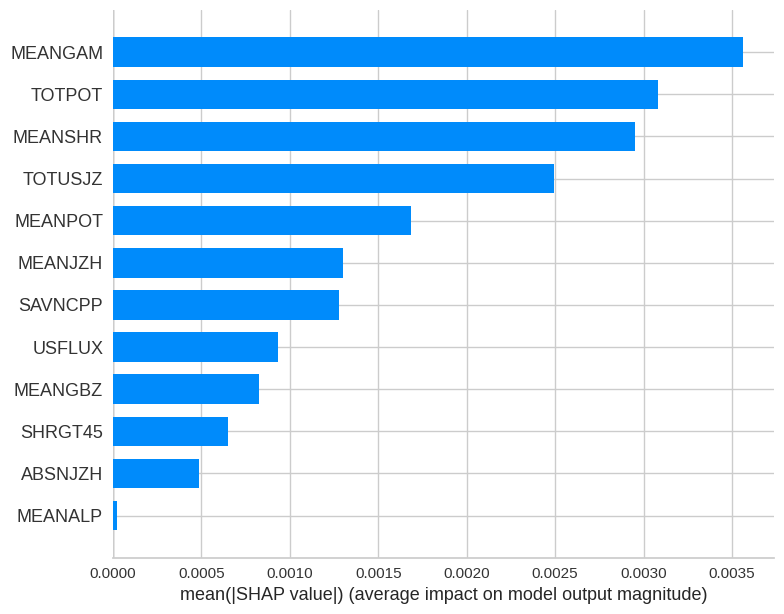

In [32]:
    shap.summary_plot(shap_values_squeezed, X_test_mean, feature_names=feature_names, plot_type="bar")

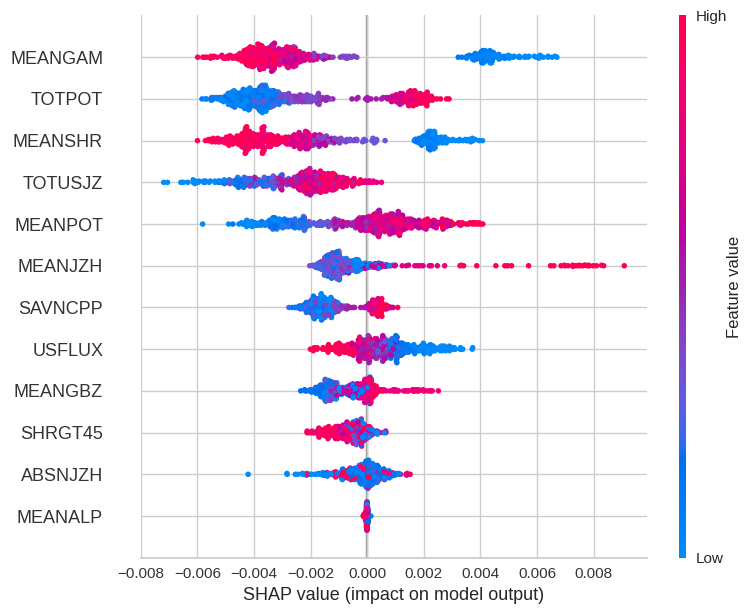

In [33]:
    shap.summary_plot(shap_values_squeezed, X_test_mean, feature_names=feature_names)

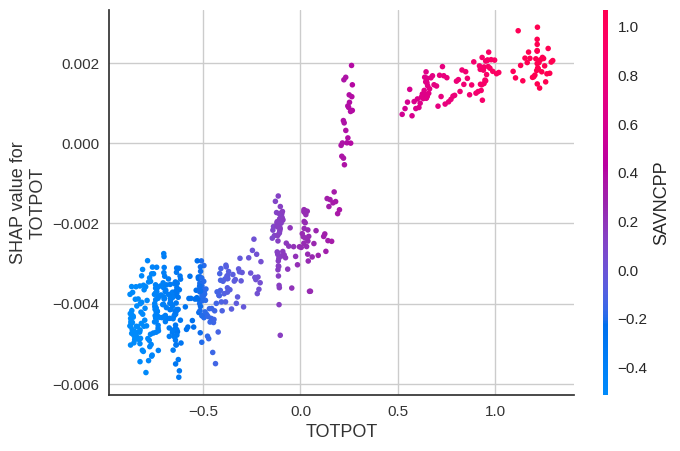

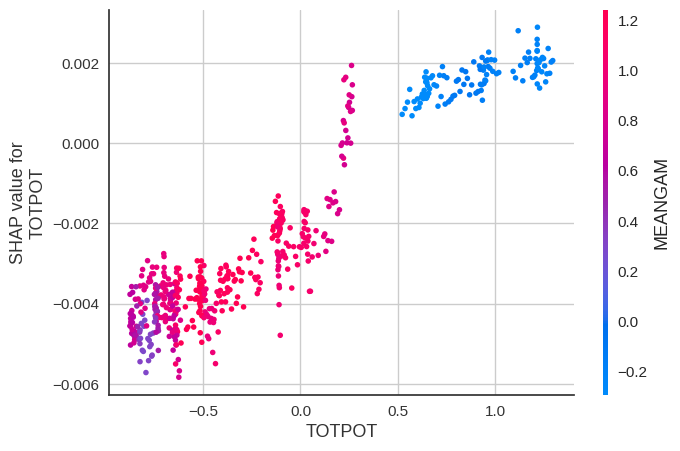

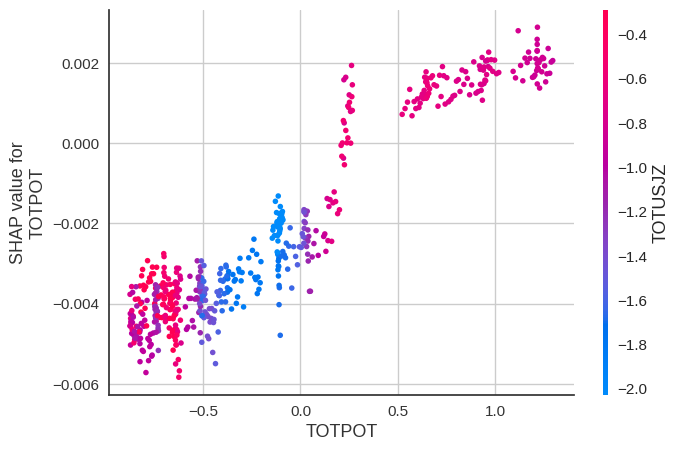

In [34]:
    # Plot 1: TOTPOT (most important + highest correlated)
    shap.dependence_plot(ind='TOTPOT', interaction_index='SAVNCPP', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

    # Plot 2: TOTPOT (most important + least correlated)
    shap.dependence_plot(ind='TOTPOT', interaction_index='MEANGAM', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

    # Plot 3: TOTPOT (most important + weakest correlated)
    shap.dependence_plot(ind='TOTPOT', interaction_index='TOTUSJZ', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

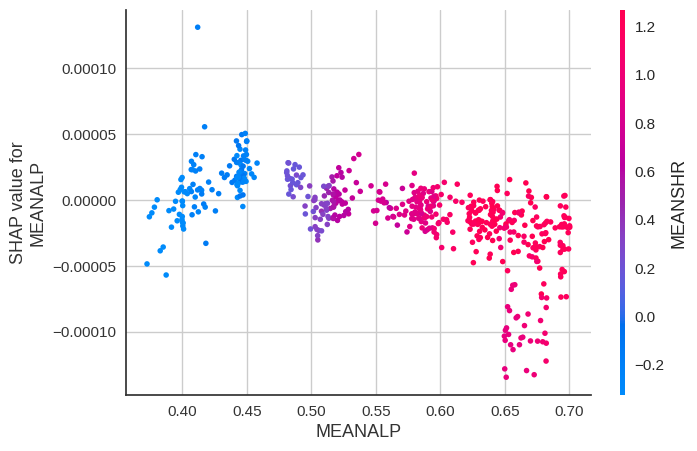

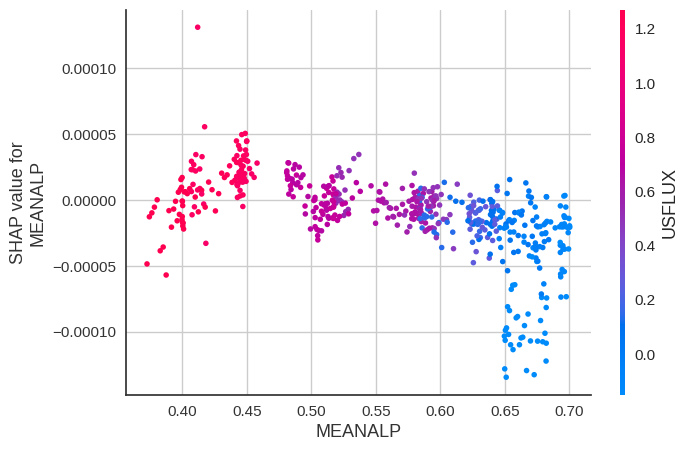

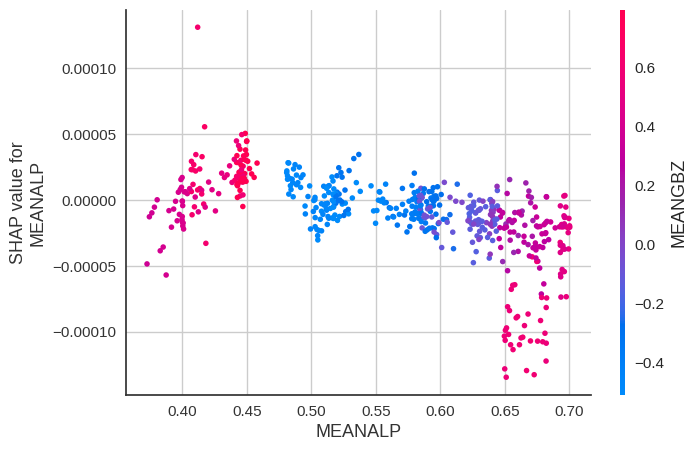

In [35]:
    # Plot 1: MEANALP (least important + highest correlated)
    shap.dependence_plot(ind='MEANALP', interaction_index='MEANSHR', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

    # Plot 2: MEANALP (most important + least correlated)
    shap.dependence_plot(ind='MEANALP', interaction_index='USFLUX', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

    # Plot 3: MEANALP (most important + weakest correlated)
    shap.dependence_plot(ind='MEANALP', interaction_index='MEANGBZ', shap_values=shap_values_squeezed, features=X_test_mean, feature_names=feature_names)

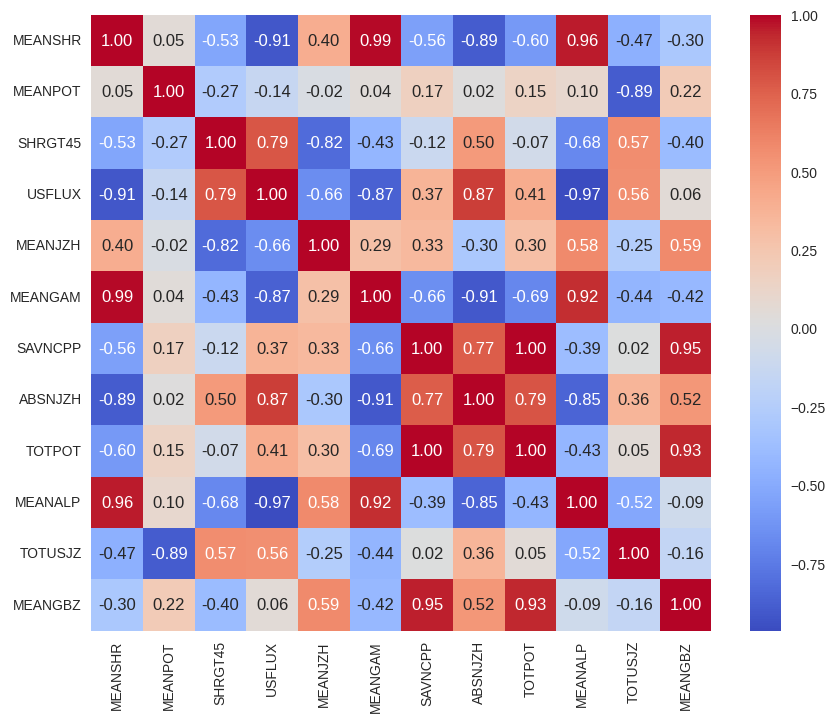

In [36]:
    import seaborn as sns

    df = pd.DataFrame(X_test_mean, columns=feature_names)
    correlation_matrix = df.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

In [37]:
    expected_value = model.predict(X_train).mean()

1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


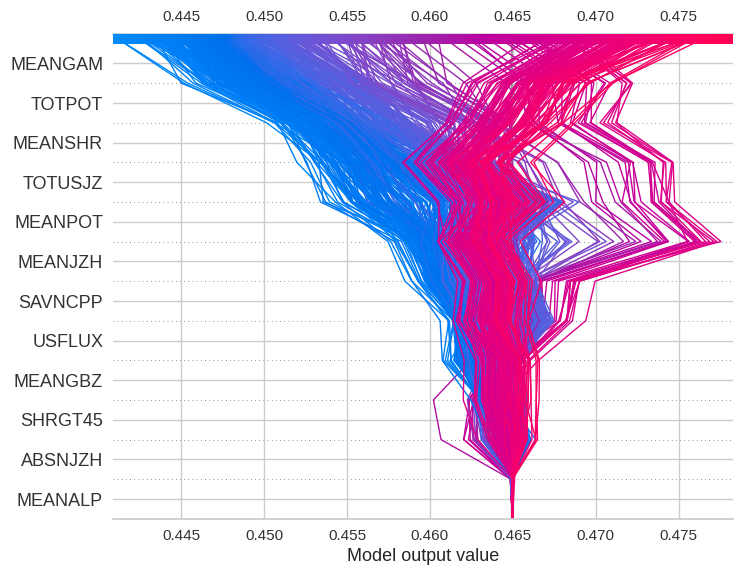

In [38]:
    shap.decision_plot(expected_value, shap_values_squeezed[:], feature_names=feature_names)

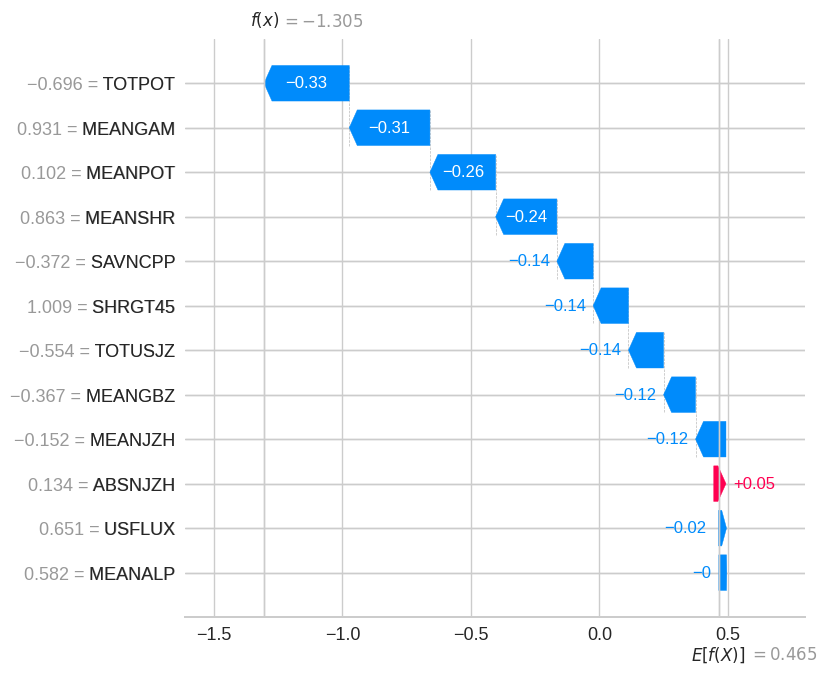

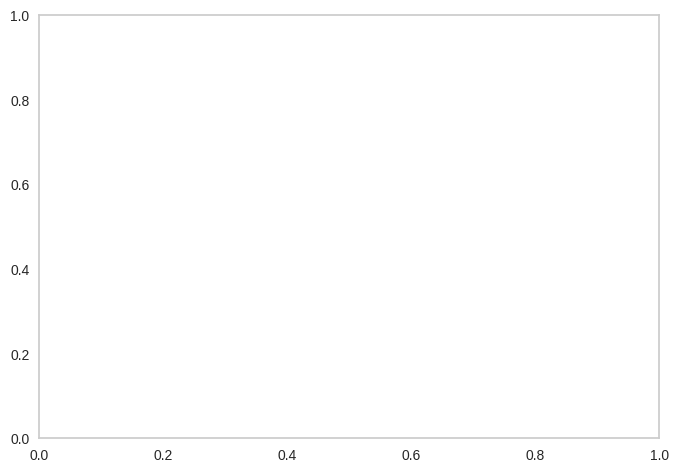

In [39]:
    scaled_values = shap_values_squeezed[300] * 100

    shap.plots.waterfall(
        shap.Explanation(
            values=scaled_values,
            base_values=expected_value,
            data=X_test_mean[300],
            feature_names=feature_names
        ),
        max_display=len(feature_names)
    )

    plt.gca().grid(False)
    ax = plt.gca()
    ax.set_axisbelow(False)
    ax.xaxis.grid(False)
    ax.yaxis.grid(False)

# **Partial Dependence Plots (PDP)**

In [40]:
    from sklearn.linear_model import RidgeClassifier

    y_pred = prob.flatten()

    ridge = RidgeClassifier()
    ridge.fit(X_test_mean, y_pred >= 0.5)

RidgeClassifier()

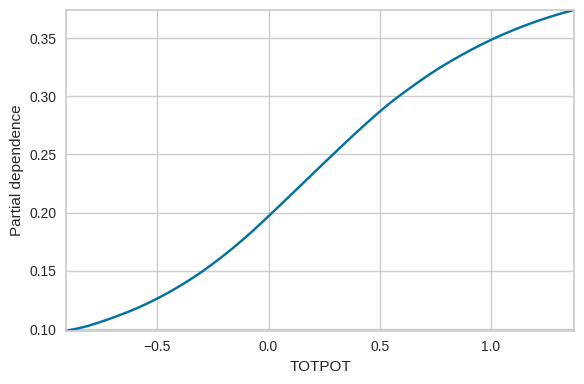

In [41]:
    import numpy as np
    import matplotlib.pyplot as plt

    feature_idx = 8   # TOTPOT

    grid_resolution = 50

    f_min, f_max = X_test[:, :, feature_idx].min(), X_test[:, :, feature_idx].max()
    f_values = np.linspace(f_min, f_max, grid_resolution)

    preds = np.zeros(grid_resolution)

    X_base = np.mean(X_test, axis=0, keepdims=True)

    for i, v in enumerate(f_values):
        X_temp = np.copy(X_base)
        X_temp[0, :, feature_idx] = v
        pred = model.predict(X_temp, verbose=0)
        preds[i] = pred[0][0]

    plt.figure(figsize=(6, 4))
    plt.plot(f_values, preds, linestyle="-")

    plt.xlim(f_min, f_max)
    plt.ylim(preds.min(), preds.max())

    plt.xlabel("TOTPOT")
    plt.ylabel("Partial dependence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [42]:
    feature_idx1 = 8   # TOTPOT
    feature_idx2 = 7   # ABSNJZH

    grid_resolution = 20

    f1_min, f1_max = X_test[:, :, feature_idx1].min(), X_test[:, :, feature_idx1].max()
    f2_min, f2_max = X_test[:, :, feature_idx2].min(), X_test[:, :, feature_idx2].max()

    f1_values = np.linspace(f1_min, f1_max, grid_resolution)
    f2_values = np.linspace(f2_min, f2_max, grid_resolution)

    X_base = np.mean(X_test, axis=0, keepdims=True)

    Z = np.zeros((grid_resolution, grid_resolution))

    for i, v1 in enumerate(f1_values):
        for j, v2 in enumerate(f2_values):
            X_temp = np.copy(X_base)
            X_temp[0, :, feature_idx1] = v1
            X_temp[0, :, feature_idx2] = v2
            pred = model.predict(X_temp, verbose=0)
            Z[i, j] = pred[0][0]

    F1, F2 = np.meshgrid(f1_values, f2_values, indexing="ij")

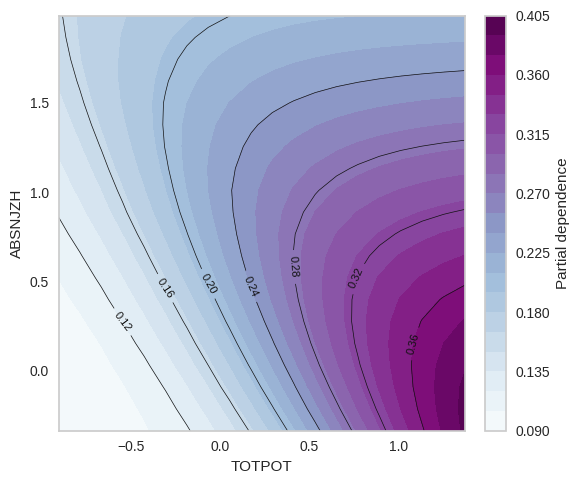

In [43]:
    plt.figure(figsize=(6, 5))

    contour = plt.contourf(
        F1, F2, Z,
        levels=20,
        cmap=plt.cm.BuPu
    )

    contour_lines = plt.contour(
        F1, F2, Z,
        colors="k",
        linewidths=0.5
    )

    plt.clabel(contour_lines, inline=True, fontsize=8)

    plt.xlabel("TOTPOT")
    plt.ylabel("ABSNJZH")

    cbar = plt.colorbar(contour, pad=0.04)
    cbar.set_label("Partial dependence")

    plt.tight_layout()
    plt.show()

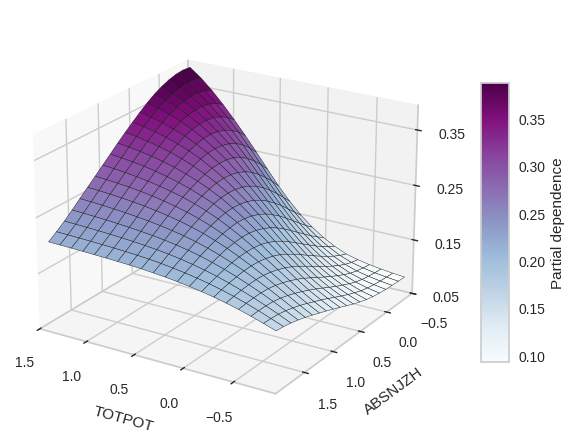

In [44]:
    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(projection="3d")

    surf = ax.plot_surface(
        F1, F2, Z,
        rstride=1, cstride=1,
        cmap=plt.cm.BuPu,
        edgecolor="k"
    )

    ax.set_xlabel("TOTPOT", labelpad=10)
    ax.set_ylabel("ABSNJZH", labelpad=10)

    ax.set_xlim(F1.min(), F1.max())
    ax.set_ylim(F2.min(), F2.max())
    ax.set_zlim(Z.min(), Z.max())

    x_ticks = ax.get_xticks()
    y_ticks = ax.get_yticks()
    z_ticks = ax.get_zticks()

    x_ticks_cleaned = [tick for i, tick in enumerate(x_ticks) if i % 2 == 0 and tick not in (-1.0, 2.0)]
    y_ticks_cleaned = [tick for i, tick in enumerate(y_ticks) if i % 2 == 0 and tick not in (-1.0, 2.0)]
    z_ticks_cleaned = [tick for i, tick in enumerate(z_ticks) if i % 2 == 0 and tick not in (-1.0, 2.0)]

    ax.set_xticks(x_ticks_cleaned)
    ax.set_yticks(y_ticks_cleaned)
    ax.set_zticks(z_ticks_cleaned)

    ax.view_init(elev=22, azim=122)
    cbar = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
    cbar.set_label("Partial dependence")

    plt.tight_layout()
    plt.show()


# **Output**

In [45]:
    print('writing prediction results into file...')
    output_result(test_data_file=test_data_file,
                  result_file=result_file,
                  type=type,
                  forecast_horizon=forecast_horizon,
                  start_feature=start_feature,
                  n_features=n_features,
                  thresh=thresh)
    print('done...')

writing prediction results into file...
done...
